## Multiclass Classification

In [143]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [144]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [145]:
from helper_functions import plot_decision_boundary

In [146]:
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Data to tensors 
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [147]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

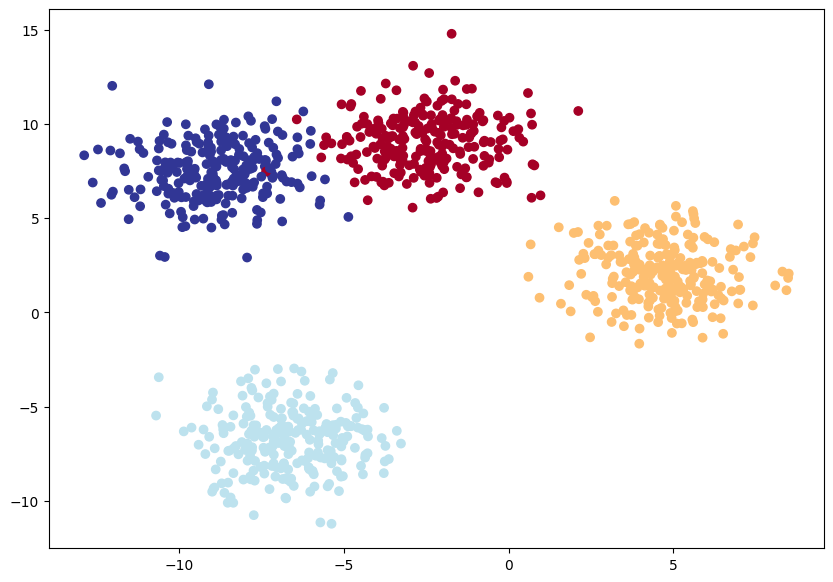

In [148]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [149]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [150]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initialize multi-class model 

        Args:
            input_features (int): num input features
            output_features (int): num output features
            hidden_units (int, optional): num hidden uits between layers. Defaults to 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

model4 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)

In [151]:
y_train[:5]

tensor([1., 0., 2., 2., 0.], device='mps:0')

In [152]:
torch.unique(y_train)

tensor([0., 1., 2., 3.], device='mps:0')

### Loss function, optimizer

In [153]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model4.parameters(),
                            lr=0.1)

### logits -> pred. probs (softmax) -> pred labels (argmax)

In [154]:
model4.eval()
with torch.inference_mode():
    y_logits = model4(X_test)

y_logits[:10]

tensor([[ 0.4360, -0.2618, -0.1064,  0.1442],
        [ 0.0474, -0.9387, -0.4596, -0.0438],
        [ 0.0039, -1.1604, -0.6468,  0.3537],
        [ 0.4114, -0.2208, -0.0243,  0.1781],
        [ 0.2839, -0.6175, -0.3745,  0.0810],
        [ 0.0189, -1.0274, -0.5459, -0.0609],
        [ 0.0268, -1.1117, -0.6128,  0.3207],
        [ 0.1638, -0.7901, -0.4107,  0.0460],
        [-0.0280, -1.1786, -0.6808,  0.4976],
        [ 0.2113, -0.7195, -0.3923,  0.0607]], device='mps:0')

In [155]:
from helper_functions import accuracy_fn, plot_decision_boundary

In [156]:
# Train model 
torch.manual_seed(42)
torch.mps.manual_seed(42)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    ### Training
    model4.train()

    y_logits = model4(X_train)  
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing 
    model4.eval()
    with torch.inference_mode():
        test_logits = model4(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if (epoch % 10 == 0):
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")
    


Epoch: 0 | Loss: 1.4282, Acc: 25.62 | Test Loss: 1.2978, Test Acc: 44.00
Epoch: 10 | Loss: 0.8020, Acc: 68.62 | Test Loss: 0.7026, Test Acc: 78.50
Epoch: 20 | Loss: 0.5443, Acc: 80.00 | Test Loss: 0.4713, Test Acc: 87.50
Epoch: 30 | Loss: 0.3654, Acc: 95.38 | Test Loss: 0.3083, Test Acc: 97.00
Epoch: 40 | Loss: 0.2504, Acc: 99.00 | Test Loss: 0.2053, Test Acc: 99.00
Epoch: 50 | Loss: 0.1703, Acc: 99.12 | Test Loss: 0.1373, Test Acc: 99.50
Epoch: 60 | Loss: 0.1144, Acc: 99.25 | Test Loss: 0.0911, Test Acc: 99.50
Epoch: 70 | Loss: 0.0799, Acc: 99.25 | Test Loss: 0.0632, Test Acc: 99.50
Epoch: 80 | Loss: 0.0609, Acc: 99.25 | Test Loss: 0.0476, Test Acc: 99.50
Epoch: 90 | Loss: 0.0501, Acc: 99.25 | Test Loss: 0.0386, Test Acc: 99.50
Epoch: 100 | Loss: 0.0437, Acc: 99.25 | Test Loss: 0.0330, Test Acc: 99.50
Epoch: 110 | Loss: 0.0395, Acc: 99.25 | Test Loss: 0.0294, Test Acc: 99.50
Epoch: 120 | Loss: 0.0366, Acc: 99.25 | Test Loss: 0.0267, Test Acc: 99.50
Epoch: 130 | Loss: 0.0345, Acc: 99.2

## Predict 

In [157]:
# Make predictions
model4.eval()
with torch.inference_mode():
    y_logits = model4(X_test)

y_logits[:10]   

tensor([[  1.8851,  12.1087,  -4.0347,  -4.8271],
        [ -0.5288, -10.1983,  -2.6446,   7.6505],
        [-11.5633,   0.1961,  11.2467,  -1.9273],
        [  0.2305,   8.4621,  -1.7888,  -3.2397],
        [  9.4680,   0.3580, -10.4795,  -0.8877],
        [ -1.5649, -12.8166,  -2.2888,   9.6628],
        [-10.0478,   1.2989,   9.9091,  -2.6421],
        [  8.7959,  -1.6189,  -9.9905,   0.1275],
        [-13.7651,  -4.1812,  13.1660,   0.5660],
        [  9.0428,  -1.0801, -10.0403,  -0.2313]], device='mps:0')

In [158]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')

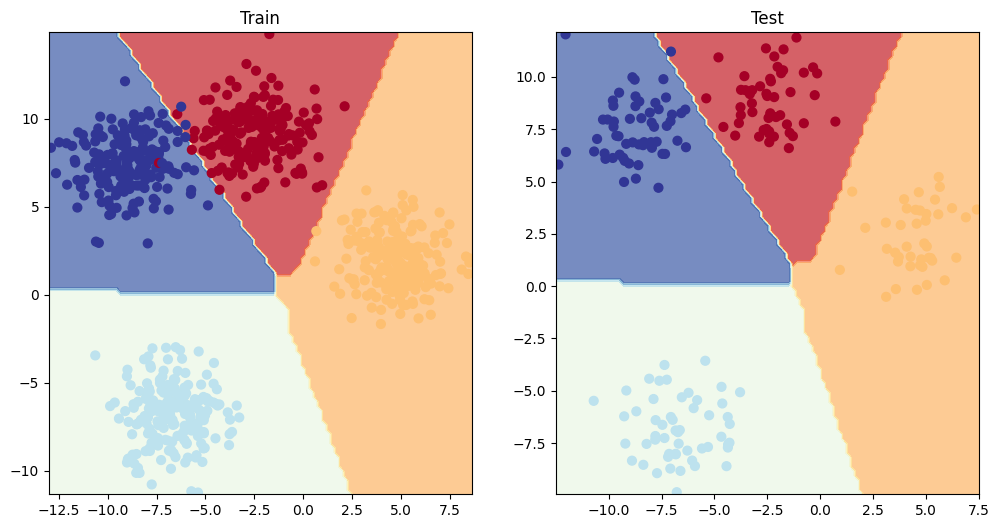

In [159]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model4, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model4, X_test, y_test)


## Metrics:
- accuracy : out of 100 samples, how many get right
- precision
- recall
- f1
- confusion matrix